# Workout Analysis

## EDA

### Importing Packages and Reading in Data

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

In [72]:
session_data = pd.read_csv('data/sessions.csv')
exercise_data = pd.read_csv('data/exercise.csv')

### Data Wrangling/Cleaning

In [73]:
data = pd.merge(session_data, exercise_data, left_on = 'Date', right_on = 'Date')

# convert dataframe columns to snake case
def to_snake_case(column):
    return (
        column.strip()
        .replace(" ", "_")
        .replace(".", "")
        .replace("-", "_")
        .lower()
    )

# Rename columns using the function
data.rename(columns=lambda col: to_snake_case(col), inplace=True)
session_data.rename(columns = lambda col: to_snake_case(col), inplace=True)

In [74]:
# Define conditions and corresponding workout types
conditions = [
    data['exercise'].isin(['Bench Press', 'Pause Bench Press', 'Incline Bench Press', 'Dumbbell Shoulder Press', 'Dumbbell Bench Press', 'Incline Dumbbell Bench Press', 'Lateral Raises', 'Chest Supported Lateral Raises', 'Pec Fly Machine', 'Egyptian Cable Lateral Raise', 'Horizontal Cable Lateral Raise', 'Lateral Raise Machine', 'Skullcrushers', 'Tricep Pushdown', 'Tricep Extensions', 'Cable Fly', 'Decline Cable Flies', 'Dips', 'Dumbbell Skullcrushers', 'Supported Incline Cable Flies', 'Military Press', 'Horizontal Cable Lateral Raise (Blom)', 'Push Ups', 'Smith Machine Incline Bench Press', 'Overhead Tricep Extension', 'Seated Overhead Press']),
    data['exercise'].isin(['Deadlift', 'Pull Ups', 'Lat Pulldown', 'Lat Pulldown Machine', 'Weight Assisted Pullups', 'Standing Lat Pullover', 'Single Arm Front Pulldown', 'Single Arm Pulldown', 'Single Arm Chest Supported Row Machine', 'Cable Row', 'Row Machine', 'Barbell Row', 'Dumbbell Row', 'Dumbbell Upright Row', 'Bicep Curls', 'Preacher Curls', 'Hammer Curl', 'EZ Bar Curls', 'Face Pulls', 'Rear Delt Cable Flies', 'Rear Delt Fly', 'Rear Delt Fly Machine', 'Lower Back Extension', 'Incline Bicep Curls', 'Rear Delt Cable Flies', 'Rear Delt Cable Flies (Blom)', 'Front Pulldown', 'Cable Bicep Curls', 'High Cable Row', 'Bent Over Dumbbell Row', 'Barbell Upright Row', 'Cable Lat Pullover', 'Single Arm Standing Chest Supported Cable Row', 'Dumbbell Preacher Curls']),
    data['exercise'].isin(['Barbell Squat', 'Smith Machine Barbell Squat', 'Leg Press Machine', 'Horizontal Leg Press Machine', 'RDL', 'Quad Extension Machine', 'Bulgarian Split Squats', 'Dumbbell Split Squats', 'Hamstring Curl Machine', 'Prone Hamstring Curls', 'Calf Raises', 'Single Leg Calf Raises', 'Calf Extension Machine', 'Glute Kickback Machine', 'Hip Abduction Machine', 'Hip Adduction Machine', 'Torso Rotation Machine', 'Leg Raises', 'Hanging Leg Raises', 'Hanging Knee Raises', 'Ab Crunch Machine', "Captain's Chair Hanging Leg Raises", 'Cable Crunches', 'Hanging Crunches']),
    data['exercise'].isin(['Stairmaster', 'Bike'])
]
choices = ['Push', 'Pull', 'Legs', 'Cardio']

# Create the new column
data['workout_type'] = np.select(conditions, choices, default=data.exercise)

In [75]:
# removes / and & from a column of values, these were used to indicate dropsets
def remove_dropset(df, column):
    df[column] = df[column].astype(str).str.split('/').str[0]  # Keep only the first number before the slash
    df[column] = df[column].astype(str).str.split(' &').str[0] 
    df[column] = df[column].astype('float64')

# clean data
columns = ['set_1_reps', 'set_2_reps', 'set_3_reps', 'set_4_reps', 'set_5_reps', 'set_1_weight', 'set_2_weight', 'set_3_weight', 'set_4_weight', 'set_5_weight']
for col in columns:
    remove_dropset(data, col)

In [ ]:
# Pivoting the table on weight and reps
long_data = data.melt(
    id_vars=[col for col in data.columns if not col.startswith("set_")],  # Keep all other columns
    value_vars=[col for col in data.columns if col.startswith("set_")],  # Only the set columns
    var_name="set_detail",
    value_name="value"
)

# Step 2: Extract the set number and type (weight or reps) from set_detail
long_data["set"] = long_data["set_detail"].str.extract(r"set_(\d+)_")[0].astype(int)
long_data["type"] = long_data["set_detail"].str.extract(r"set_\d+_(\w+)")[0]

# Step 3: Pivot the data to get weight and reps as separate columns for each set
pivot_data = long_data.pivot(
    # Keep non-set related columns
    columns=["set", "type"],  # Set number and type as columns
    values="value"
)

# create separate dataframes for weight and reps
df_weight = long_data[long_data['type'] == 'weight'].drop(columns='type')
df_reps = long_data[long_data['type'] == 'reps'].drop(columns='type')

# Merge the weight and reps dataframes on the common columns
set_df = pd.merge(df_weight, df_reps, on=['date', 'duration', 'starting_time', 'energy_level', 'fasted', 'group', 'preworkout', 'location', 'comments_x', 'comments_y', 'exercise', 'set', 'exercise', 'workout_type'], suffixes=('_weight', '_reps'))

# rename columns
set_df = set_df.rename(columns = {'value_reps': 'reps', 'value_weight': 'weight'})

# removing original columns
set_df = set_df.drop(['set_detail_reps', 'set_detail_weight'], axis = 1)

# drop NA values
set_df = set_df.dropna(subset=['weight', 'reps'])


# converting weight and reps to floats
remove_dropset(set_df, 'weight')
remove_dropset(set_df, 'reps')

# converting strings to cat
set_df[set_df.select_dtypes(include=['object', 'string']).drop(columns={'date','starting_time','comments_x','comments_y'}).columns] = \
    set_df[set_df.select_dtypes(include=['object', 'string']).drop(columns=exclude_cols).columns].apply(lambda col: col.astype('category'))



# converting dates and times to integers
## HIGHLY PRIMITIVE METHOD JUST FOR FIRST RUN

set_df['date'] = pd.to_numeric(pd.to_datetime(set_df['date']))
set_df['starting_time'] = set_df['starting_time'].str.replace(":", "", regex=False)

set_df

TypeError: Invalid object type at position 0

### Missingness

In [77]:
data.isna().sum()

date                0
duration           29
starting_time      20
energy_level       20
fasted              0
group               0
preworkout        281
location          132
comments_x       1264
exercise            0
set_1_weight        2
set_1_reps          2
set_2_weight       53
set_2_reps         55
set_3_weight      528
set_3_reps        539
set_4_weight     1376
set_4_reps       1382
set_5_weight     1573
set_5_reps       1573
comments_y       1379
workout_type        0
dtype: int64

Expectedly, comments have a large amount of missingness 

Concerningly, there exist a mismatched number of weight and rep missingness, suggesting that some sets have only weights without reps

We will first deal with missing values for set 1, as there should never be a set with no reps or weight

In [78]:
data[data.set_1_weight.isna() == True]

,date,duration,starting_time,energy_level,fasted,group,preworkout,location,comments_x,exercise,...,set_2_weight,set_2_reps,set_3_weight,set_3_reps,set_4_weight,set_4_reps,set_5_weight,set_5_reps,comments_y,workout_type
878,1/28/2024,60.0,17:20,6.0,0,1,0.0,Blomquist,Liz,Leg Raises,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Partner Ab workout,Legs
1350,7/8/2024,75.0,14:44,7.0,0,0,0.0,NaN,NaN,Tricep Pushdown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Push


These values are completely missing for all sets and must be discarded

In [79]:
data.dropna(subset = ['set_1_weight'])

,date,duration,starting_time,energy_level,fasted,group,preworkout,location,comments_x,exercise,...,set_2_weight,set_2_reps,set_3_weight,set_3_reps,set_4_weight,set_4_reps,set_5_weight,set_5_reps,comments_y,workout_type
0,5/9/2023,NaN,NaN,NaN,0,0,NaN,Blomquist,NaN,Bench Press,...,145.0,6.0,135.0,7.0,NaN,NaN,NaN,NaN,Warmup - 95 x 6,Push
1,5/9/2023,NaN,NaN,NaN,0,0,NaN,Blomquist,NaN,Dumbbell Shoulder Press,...,40.0,7.0,40.0,7.0,35.0,7.0,NaN,NaN,NaN,Push
2,5/9/2023,NaN,NaN,NaN,0,0,NaN,Blomquist,NaN,Incline Dumbbell Bench Press,...,35.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Push
3,5/9/2023,NaN,NaN,NaN,0,0,NaN,Blomquist,NaN,Lateral Raises,...,15.0,12.0,15.0,10.0,10.0,12.0,NaN,NaN,NaN,Push
4,5/9/2023,NaN,NaN,NaN,0,0,NaN,Blomquist,NaN,Pec Fly Machine,...,90.0,10.0,90.0,12.0,NaN,NaN,NaN,NaN,NaN,Push
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,9/10/2024,83.0,19:05,8.0,0,1,1.0,First Baptist,NaN,Lateral Raises,...,15.0,16.0,15.0,12.0,NaN,NaN,NaN,NaN,superdrop,Push
1579,9/10/2024,83.0,19:05,8.0,0,1,1.0,First Baptist,NaN,Dips,...,0.0,8.0,0.0,7.0,NaN,NaN,NaN,NaN,NaN,Push
1580,9/10/2024,83.0,19:05,8.0,0,1,1.0,First Baptist,NaN,Horizontal Cable Lateral Raise,...,7.5,14.0,7.5,12.0,NaN,NaN,NaN,NaN,superset,Push
1581,9/10/2024,83.0,19:05,8.0,0,1,1.0,First Baptist,NaN,Cable Fly,...,25.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,superset,Push


Now we can impute missing values for Reps where we already have weights

In [80]:
# impute here

### Distribution Exploration

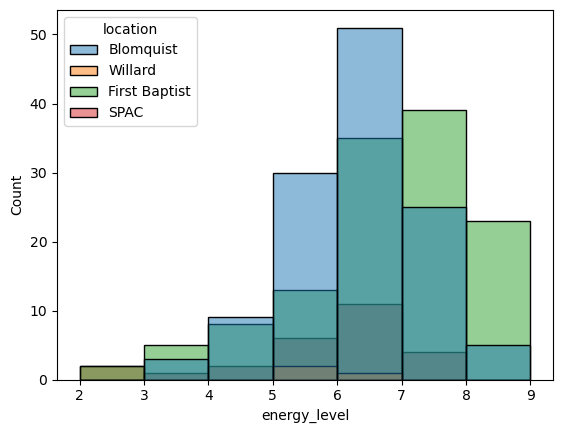

In [81]:
plot = sns.histplot(data=session_data,
                    x = 'energy_level',
                    bins = 7,
                    kde = False,
                    hue = 'location')

- Energy Level is left skew with mean around 6-7 out of 10

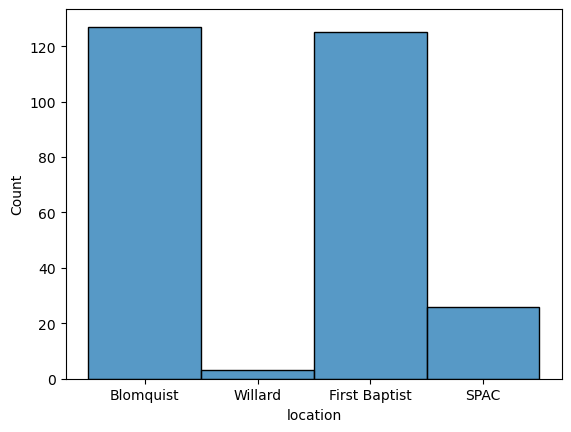

In [82]:
plot = sns.histplot(data = session_data,
                    x = "location")

- Large majority of workouts at Blomquist or First Baptist

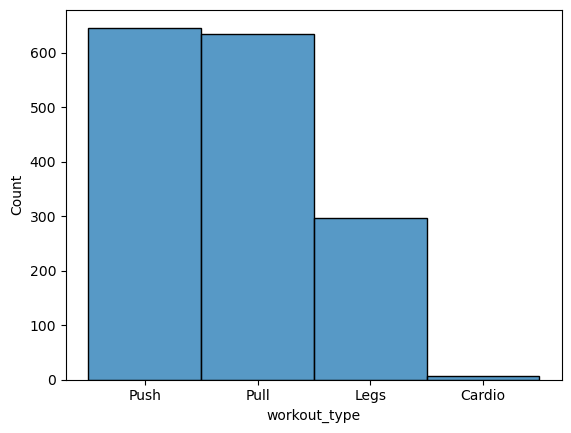

In [83]:
plot = sns.histplot(data = data,
                    x = 'workout_type')

- Roughly equal amount of Push and Pull workouts \n
- Almost half as many Leg workouts

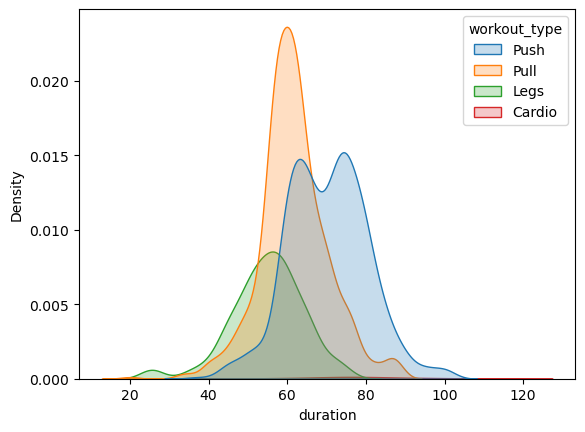

In [84]:
plot = sns.kdeplot(data = data,
                    x = 'duration',
                    fill = True,
                    hue = 'workout_type')

- Intersetingly, Push workouts seem to be bimodally distributed around 60 and 80 minutes
    - Lets explore this further...
- Pull workouts are generally normally distributed around 60 minutes
- Legs workouts are slightly left skew with a peak slightly below 60 minutes as well

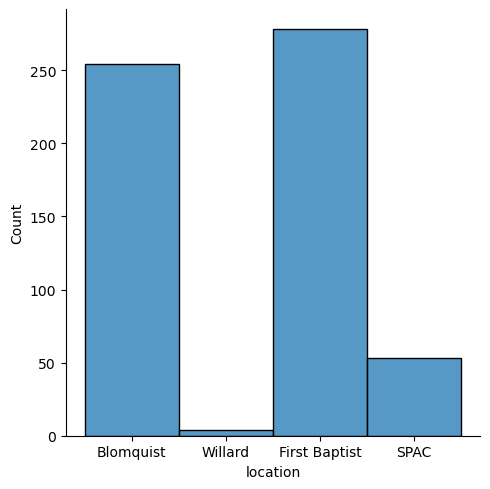

In [85]:
plot = sns.displot(data = data[data['workout_type'] == 'Push'],
                   x = 'location')

- Similarly to the distribution of all workout types, most Push workouts occur at Blomquist or First Baptist

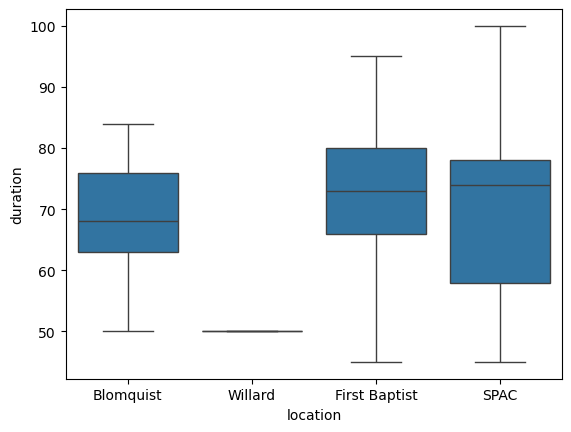

In [86]:
plot = sns.boxplot(data = data[data['workout_type'] == 'Push'],
                   x = 'location',
                   y = 'duration')

- We can see that Push workouts at First Baptist and SPAC generally last longer than those at Blomquist, likely accounting for the bimodal distribution observed earlier

### Weights and Reps

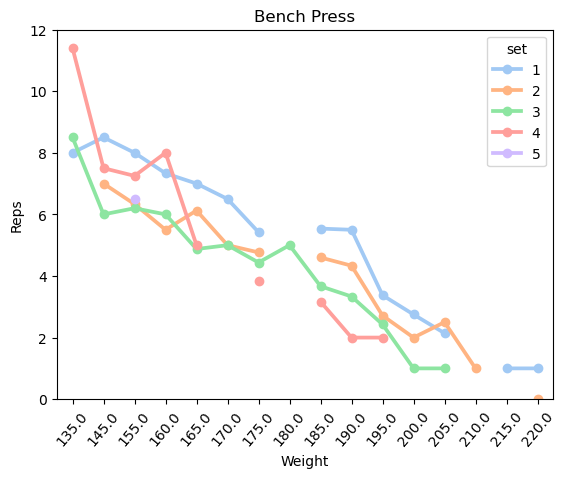

In [87]:
plot = sns.pointplot(data = set_df[set_df.exercise == 'Bench Press'],
                   y = 'reps',
                   x = 'weight',
                   hue = 'set',
                   markersize = 5,
                   palette = 'pastel',
                   errorbar = None)
plot.set(ylabel = 'Reps',
         xlabel = 'Weight',
         title = 'Bench Press',
         ylim = [0, 12])
plot.tick_params(axis = 'x', labelrotation = 50)


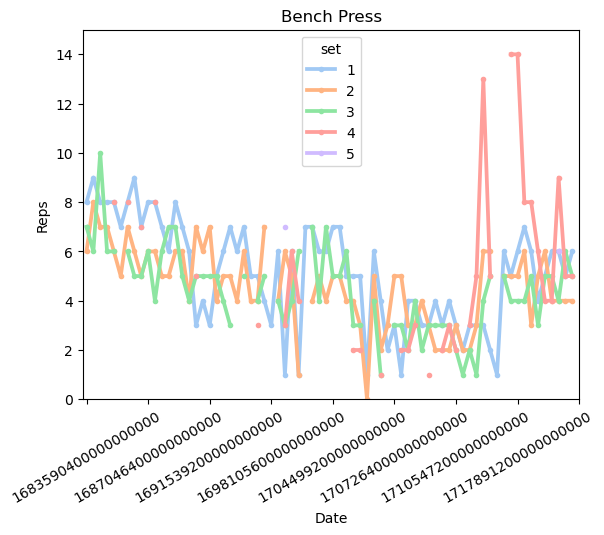

In [88]:
plot = sns.pointplot(data = set_df[set_df.exercise == 'Bench Press'],
                   y = 'reps',
                   x = 'date',
                   hue = 'set',
                   palette = 'pastel',
                   markersize = 2,
                   errorbar = None)
plot.set(ylabel = 'Reps',
         xlabel = 'Date',
         title = 'Bench Press',
         ylim = [0, 15],
         xticks = range(0, 80, 9))
plot.tick_params(axis = 'x', labelrotation = 30)


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


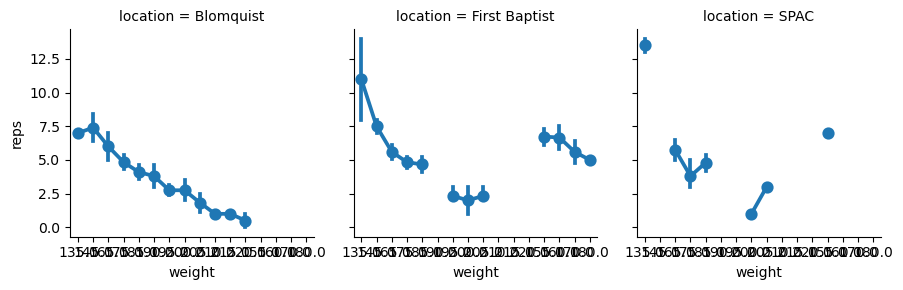

In [89]:
plot = sns.FacetGrid(set_df[set_df.exercise == 'Bench Press'], col = 'location')
plot.map(sns.pointplot, 'weight', 'reps')

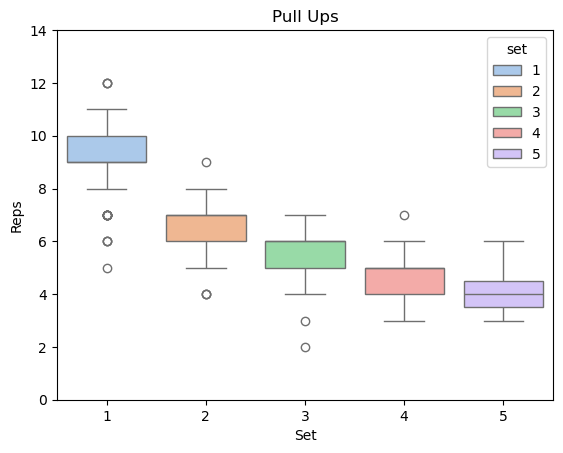

In [90]:
plot = sns.boxplot(data = set_df[set_df.exercise == 'Pull Ups'],
                   y = 'reps',
                   x = 'set',
                   hue = 'set',
                   palette = 'pastel')
plot.set(ylabel = 'Reps',
         xlabel = 'Set',
         title = 'Pull Ups',
         ylim = [0, 14])
plot.tick_params(axis = 'x', labelrotation = 0)


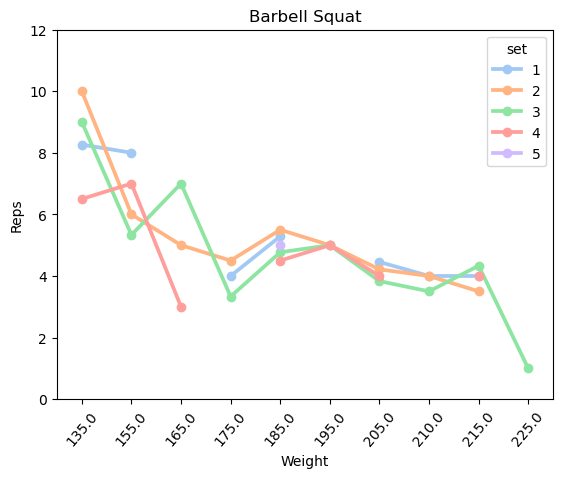

In [91]:
plot = sns.pointplot(data = set_df[set_df.exercise == 'Barbell Squat'],
                   y = 'reps',
                   x = 'weight',
                   hue = 'set',
                   markersize = 5,
                   palette = 'pastel',
                   errorbar = None)
plot.set(ylabel = 'Reps',
         xlabel = 'Weight',
         title = 'Barbell Squat',
         ylim = [0, 12])
plot.tick_params(axis = 'x', labelrotation = 50)


# Model Creation

- Would like to create a model that predicts the rep count of a given set

In [92]:
#our dataset will be set_df
set_df

,date,duration,starting_time,energy_level,fasted,group,preworkout,location,comments_x,exercise,comments_y,workout_type,weight,set,reps
0,1683590400000000000,NaN,NaN,NaN,0,0,NaN,Blomquist,NaN,Bench Press,Warmup - 95 x 6,Push,145.0,1,8.0
1,1683590400000000000,NaN,NaN,NaN,0,0,NaN,Blomquist,NaN,Dumbbell Shoulder Press,NaN,Push,40.0,1,8.0
2,1683590400000000000,NaN,NaN,NaN,0,0,NaN,Blomquist,NaN,Incline Dumbbell Bench Press,NaN,Push,35.0,1,4.0
3,1683590400000000000,NaN,NaN,NaN,0,0,NaN,Blomquist,NaN,Lateral Raises,NaN,Push,15.0,1,12.0
4,1683590400000000000,NaN,NaN,NaN,0,0,NaN,Blomquist,NaN,Pec Fly Machine,NaN,Push,70.0,1,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7661,1719100800000000000,68.0,1352,7.0,0,1,1.0,First Baptist,NaN,Pull Ups,NaN,Pull,0.0,5,5.0
7672,1719360000000000000,57.0,1348,6.0,0,0,1.0,First Baptist,NaN,Pull Ups,NaN,Pull,0.0,5,4.0
7694,1721174400000000000,58.0,2007,7.0,0,1,1.0,First Baptist,NaN,Pull Ups,NaN,Pull,0.0,5,4.0
7809,1724284800000000000,62.0,1936,7.0,0,1,1.0,First Baptist,busted hand,Pull Ups,NaN,Pull,0.0,5,4.0


In [93]:
# some variables will likely require some imputation
set_df.isna().sum()


date                0
duration           86
starting_time      62
energy_level       62
fasted              0
group               0
preworkout        745
location          351
comments_x       3482
exercise            0
comments_y       3800
workout_type        0
weight              0
set                 0
reps                0
dtype: int64

In [94]:
from sklearn.model_selection import train_test_split

x = set_df.drop(columns = {'comments_x', 'comments_y', 'reps'})
y = set_df[['reps']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1500)

## Baseline Model

We will be using a linear regression as our baseline model

In [95]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(x_train, y_train)

ValueError: could not convert string to float: 'Blomquist'